In [1]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import scFates as scf
import matplotlib.pyplot as plt

In [2]:
pth = os.path.join('..', '..')
pth_data = os.path.join(pth, 'data')
pth_in = os.path.join(pth_data, 'modeling', 'inputs')
pth_traj = os.path.join(pth_data, 'trajectories')
pth_delay = os.path.join(pth_data, 'DELAY')
# pth_out = os.path.join(pth, 'figures', 'modeling', '')

In [3]:
adata = sc.read_h5ad(os.path.join(pth_in, 'development.h5ad'))
adata

AnnData object with n_obs × n_vars = 143369 × 856
    obs: 'Stages', 'Clusters', 'Type', 'LineageAnnotations', 'celltype', 'trajectory', 't', 'training', 'validation', 'sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'plates', 'devtime', 'location', 'total_counts_ERCC', 'pct_counts_ERCC', 'doublet_scores', 'CytoTRACE', 'Gut_neuron', 'Sensory', 'Symp', 'enFib', 'ChC', 'Gut_glia', 'NCC', 'Mesenchyme', 'Melanocytes', 'SatGlia', 'SC', 'BCC', 'conflict', 'assignments', 'Hub', 'Hub_leiden', 'total_counts_ribo', 'pct_counts_ribo', 'T+ Sox2+', 'batch', 'percent_mito', 'n_counts', 'bh_pval', 'region', 'tissue', 'adj_stage', 'adj_sample', 'S_score', 'G2M_score', 'phase', 'leiden_R', 'celltype_original', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'RNA_snn_res.0.1', 'seurat_clusters', 'age', 'RNA_snn_res.0.5', 'ident', 'velocity_self_transition', 'source', 'weight_celltype', 'weight_source', 'weight'
    obsm: 'X_diff', 'X_draw_graph_fa', 'X_

In [18]:
for reg, net in (('Gsc', 'early'), ('Foxc1', 'late')):
    name = f'{reg}_gene'
    print(name)
    # pth_reg = os.path.join(pth_delay, net, 'regulons', f'{reg}.csv')
    # g = pd.read_csv(pth_reg).mmusculus
    # g = g.loc[g.isin(adata.var_names)]
    for _, df_group in adata.obs.groupby('source', observed = True):
        msk = adata.obs_names.isin(df_group.index)
        adata_group = adata[msk].copy()
        sc.tl.score_genes(adata_group,
                          gene_list = [reg],
                          ctrl_as_ref = False,
                          score_name = name,
                          random_state = 1234)
        adata.obs.loc[msk, name] = adata_group.obs[name]

Gsc_gene
Foxc1_gene


In [19]:
cmap = {'Gsc_gene' : 'Blues', 'Foxc1_gene' : 'Reds'}

/home/caleb/miniconda3/envs/scFates/lib/python3.11/site-packages/anndata/_core/anndata.py:381: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


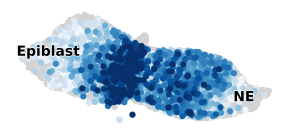

In [6]:
geo, reg_plt = 'GSE162534', ['Gsc_gene']
vmin, vmax = {'Gsc_gene' : 0, 'Foxc1_gene' : 1}, 'p95'
adata_plt = adata[adata.obs.source == geo].copy()
adata_traj = sc.read_h5ad(os.path.join(pth_traj, f'{geo}.h5ad'))
adata_traj = adata_traj[adata_traj.obs_names.isin(adata_plt.obs_names)].copy()
adata_traj.obs[reg_plt] = adata_plt[adata_traj.obs_names].obs[reg_plt].copy()

fig, ax = plt.subplots(1, 1, figsize = (3.5, 1.5))
sc.pl.umap(adata_traj, palette = 'lightgray', size = 80,
           frameon = False, show = False, ax = ax)
for reg in reg_plt:
    sc.pl.umap(adata_traj[adata_traj.obs[reg] > vmin[reg]],
               color = reg, size = 80, cmap = cmap[reg],
               vmin = vmin[reg], vmax = vmax, colorbar_loc = None,
               frameon = False, show = False, ax = ax)
scf.pl.milestones(adata_traj, basis = 'umap', annotate = True,
                  alpha = 0, show = False, ax = ax)
ax.invert_xaxis(); ax.set_title('')

label_dict = {
    'Lateral Plate Mesoderm' : 'NE',
    'Posterior Epiblast'     : 'Epiblast'}

for label in ax.texts:
    _label_ = label.get_text()
    if _label_ in label_dict:
        label.set_text(label_dict[_label_])

# fn = os.path.join(pth_out, f'{geo}.pdf')
# plt.savefig(fn, bbox_inches = 'tight')
plt.show()

In [ ]:
# geo, mod_plt = 'GSE229103', ['Early', 'Late']
# vmin, vmax = {'Early' : .2, 'Late' : -.005}, 'p95'
# adata_plt = adata[adata.obs.source == geo].copy()
# adata_traj = sc.read_h5ad(os.path.join(pth_traj, f'{geo}.h5ad'))
# adata_traj = adata_traj[adata_traj.obs_names.isin(adata_plt.obs_names)].copy()
# adata_traj.obs[mod_plt] = adata_plt[adata_traj.obs_names].obs[mod_plt].copy()

# fig, ax = plt.subplots(1, 1, figsize = (3.5, 1.5))
# sc.pl.umap(adata_traj, dimensions = [1, 0], palette = 'lightgray',
#            size = 80, frameon = False, show = False, ax = ax)
# for mod in mod_plt:
#     sc.pl.umap(adata_traj[adata_traj.obs[mod] > vmin[mod]],
#                dimensions = [1, 0], color = mod, size = 80,
#                cmap = cmap[mod], vmin = vmin[mod], vmax = vmax,
#                colorbar_loc = None, frameon = False, show = False,
#                ax = ax)
# sc.pl.umap(adata_traj, dimensions = [1, 0], color = 'milestones',
#            alpha = 0, legend_loc = 'on data', legend_fontoutline = 1,
#            show = False, ax = ax)
# ax.invert_xaxis(); ax.set_title('')

# label_dict = {
#     'Presomitic Mesoderm'        : 'PSM',
#     'Neuromesodermal Progenitor' : 'NMP'}

# pos_dict = {
#     'Neuromesodermal Progenitor' : (1.5, -1.75),
#     'Presomitic Mesoderm'        : (-1.33, 1.75)}

# for label in ax.texts:
#     _label_ = label.get_text()
#     x, y = label.get_position()
#     if _label_ in label_dict:
#         label.set_text(label_dict[_label_])
#     if _label_ in pos_dict:
#         dx, dy = pos_dict[_label_]
#         label.set_position([x + dx, y + dy])

# fn = os.path.join(pth_out, f'{geo}.pdf')
# plt.savefig(fn, bbox_inches = 'tight')

/home/caleb/miniconda3/envs/scFates/lib/python3.11/site-packages/anndata/_core/anndata.py:381: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


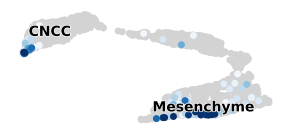

In [22]:
geo, reg_plt = 'rRNAModifications', ['Gsc_gene']
vmin = {'Gsc_gene' : 0, 'Foxc1_gene' : .2}
vmax = {'Gsc_gene' : 'p90', 'Foxc1_gene' : 'p95'}
adata_plt = adata[adata.obs.source == geo].copy()
adata_traj = sc.read_h5ad(os.path.join(pth_traj, f'{geo}.h5ad'))
adata_traj = adata_traj[adata_traj.obs_names.isin(adata_plt.obs_names)].copy()
adata_traj.obs[reg_plt] = adata_plt[adata_traj.obs_names].obs[reg_plt].copy()

fig, ax = plt.subplots(1, 1, figsize = (3.5, 1.5))
sc.pl.umap(adata_traj, palette = 'lightgray', size = 100,
           frameon = False, show = False, ax = ax)
for reg in reg_plt:
    sc.pl.umap(adata_traj[adata_traj.obs[reg] > vmin[reg]],
               color = reg, cmap = cmap[reg], vmin = vmin[reg],
               vmax = vmax[reg], size = 100, colorbar_loc = None,
               frameon = False, show = False, ax = ax)
scf.pl.milestones(adata_traj, basis = 'umap', annotate = True,
                  alpha = 0, show = False, ax = ax)
ax.invert_yaxis(); ax.set_title('')

label_dict = {
    'migr_ncc'   : '',
    'mes_fork'   : '',
    'mes2'       : '',
    'neuroglial' : '',
    'root'       : 'CNCC',
    'mes1'       : 'Mesenchyme'}

pos_dict = {
    'root' : (.75, -1.25),
    'mes1' : (1.75, -.25)}

for label in ax.texts:
    _label_ = label.get_text()
    x, y = label.get_position()
    if _label_ in label_dict:
        label.set_text(label_dict[_label_])
    if _label_ in pos_dict:
        dx, dy = pos_dict[_label_]
        label.set_position([x + dx, y + dy])

# fn = os.path.join(pth_out, f'{geo}.pdf')
# plt.savefig(fn, bbox_inches = 'tight')
plt.show()